# <div align="center"><b> TRABAJO FINAL - ANÁLISIS DE SERIES TEMPORALES - MIA </b></div>

<div align="right">📝 <em><small><font color='Gray'>Nota:</font></small></em></div>

<div align="right"> <em><small><font color='Gray'> La funcionalidad de visualización de jupyter notebooks en <a href="https://github.com/" target="_blank">github</a> es solamente un preview.</font></small></em> </div>

<div align="right"> <em><small><font color='Gray'> Para mejor visualización se sugiere utilizar el visualizador recomndado por la comunidad: <a href="https://nbviewer.org/" target="_blank">nbviewer</a></font></small></em> </div>

<div align="right"> <em><small><font color='Gray'> Puedes a acceder al sigiente enlace para ver este notebook en dicha página: <a href="https://nbviewer.org/github/brunomaso1/uba-mia/blob/mia-ast1/mia-ast1/Trabajo%20final/tp-final.ipynb">Trabajo final</a></font></small></em> </div>

* * *

<style>
/* Limitar la altura de las celdas de salida en html */
.jp-OutputArea.jp-Cell-outputArea {
    max-height: 500px;
}
</style>

🛻 <em><font color='MediumSeaGreen'>  Instalaciones: </font></em> 🛻

Este notebook utiliza Poetry para la gestión de dependencias. Para instalar las dependencias necesarias, instala Poetry y ejecuta el siguiente comando en la raíz del proyecto:

```bash
poetry install
# Activa el entorno virtual de Poetry
eval $(poetry env activate)
```

✋ <em><font color='DodgerBlue'>Importaciones:</font></em> ✋

In [1]:
# Sistema y manejo de archivos
import os
import datetime

# Manejo de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import mplfinance as mpf
from tqdm.notebook import tqdm
from wand.image import Image as WImage

# Modelado y análisis de series temporales
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt
from pmdarima import auto_arima
from prophet import Prophet

# Machine Learning
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor

# Deep Learning
# NOTA: Backend keras = TensorFlow
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input

# API y configuración
from dotenv import load_dotenv
from binance.client import Client

import warnings
warnings.filterwarnings('ignore')

Importing plotly failed. Interactive plots will not work.


🔧 <em><font color='tomato'>Configuraciones:</font></em> 🔧


In [2]:
load_dotenv()

BINANCE_API_KEY = os.getenv("BINANCE_API_KEY")
BINANCE_API_SECRET = os.getenv("BINANCE_API_SECRET")


BASE_FOLDER_PATH = os.getcwd() # Trabajo Final
DATASET_FOLDER_PATH = os.path.join(BASE_FOLDER_PATH, "datasets") # Trabajo Final/dataset
DATASET_CSV_FILE_PATH = os.path.join(DATASET_FOLDER_PATH, "BTCUSDT_1D.csv") # Trabajo Final/dataset/BTCUSDT_1D.csv
DATASET_PICKLE_FILE_PATH = os.path.join(DATASET_FOLDER_PATH, "BTCUSDT_1D.pkl") # Trabajo Final/dataset/BTCUSDT_1D.pkl

LABEL_FONTSIZE = 10
TITLE_FONTSIZE = 16

<!-- Colab -->
<!-- <div align="center"><img src="https://drive.google.com/uc?export=view&id=1QSNrTsz1hQbmZwpgwx0qpfpNtLW19Orm" width="600" alt="Figura 1: A data scientist is working on word generation using the Lord of the Rings lore. The image is dark and moody, with a focus on the scientist's computer screen. The screen displays a visualization the one ring, with a map of Middle Earth in the background. - Generada con DALL-E3"></div> -->

<div align="center"><img src="../resources/portada.jpeg" width="600" alt="Figura 1: A data scientist is sitting in front of a computer screen, intently focused on the task at hand. The room is dimly lit, with the only light coming from the computer screen. The scientist is predicting the prices of Bitcoin using a statistical model, like ARIMA. - Generada con Microsoft Image Creator"></div>

<div align="center"><small><em>Figura 1: Imagen generada con Microsoft Image Creator</em></small></div>

<div align="center">✨Datos del proyecto:✨</div>

<p></p>

<div align="center">

| Subtitulo       | Trabajo final - Análisis de series temporales 1 - FIUBA                                                                                |
| --------------- | -------------------------------------------------------------------------------------------------------------------------------------- |
| **Descrpción**  | Bitcoin $\leftrightarrow$ USDT                                                                                                                         |
| **Integrantes** | - Bruno Masoller (brunomaso1@gmail.com)<br/>- Juan Cruz Ferreyra (ferreyra.juancruz95@gmail.com)<br/>- Francisco Rassi (franciscorassi@gmail.com)                                                                                                  |

</div>

<details>
    <summary><u>Tabla de contenido</u> ⬇️</summary>

- [Consigna](#consigna)
- [Resolución](#resolución)
    - [Contexto](#contexto)
    - [Objetivos específicos](#objetivos-específicos)
    - [Carga de datos](#carga-de-datos)
    - [Análisis de datos](#análisis-de-datos)
    - [Modelos de series temporales](#modelos-de-series-temporales)
    - [Conclusiones](#conclusiones)
    - [Mejoras futuras](#mejoras-futuras)

</details>

## Consigna <a class="anchor" id="consigna"></a>

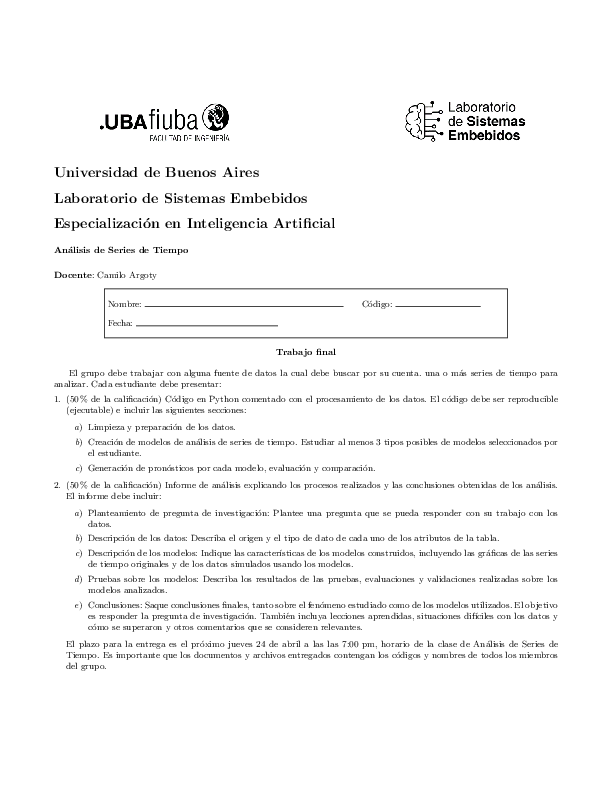

In [3]:
WImage(filename='TP_final_AST_01MA2025.pdf')

## Resolución <a class="anchor" id="resolución"></a>

### Contexto <a class="anchor" id="contexto"></a>

[Binance](https://binance.com) es una plataforma de intercambio de criptomonedas que permite a los usuarios comprar, vender e intercambiar una variedad de criptomonedas. Fundada en 2017, Binance se ha convertido en uno de los intercambios más grandes y populares del mundo, ofreciendo una amplia gama de servicios relacionados con criptomonedas, incluyendo comercio al contado, comercio de futuros, préstamos y ahorros en criptomonedas, y más.

Como parte de su oferta, Binance proporciona una API (Interfaz de Programación de Aplicaciones) que permite a los desarrolladores acceder a datos de mercado, realizar operaciones y gestionar cuentas programáticamente. Esta API es ampliamente utilizada por traders algorítmicos, desarrolladores de aplicaciones y otros interesados en el ecosistema de criptomonedas.

El objetivo general de este trabajo es analizar el comportamiento de los precios de las criptomonedas a través de la API de Binance. Se utilizará datos históricos de precios para realizar un análisis exploratorio y aplicar técnicas de análisis de series temporales. A lo largo del trabajo, abordaremos los siguientes puntos:
- Descripción de la API de Binance y su funcionalidad.
- Planteo de objetivos específicos desafiantes.
- Obtención de datos históricos de precios de criptomonedas a través de la API.
- Análisis exploratorio de los datos obtenidos.
- Aplicación de técnicas de análisis de series temporales para modelar y predecir el comportamiento de los precios.
- Discusión de los resultados y conclusiones.
- Recomendaciones para futuros trabajos y mejoras en el análisis.

<details>
  <summary>Conocimientos básicos ⬇️</summary>

**API Binance**

La API pública de Binance ofrece un conjunto completo de datos de mercado históricos para todos los símbolos soportados, organizados en archivos diarios y mensuales, cubriendo tanto Spot como los dos tipos de Futuros (USDⓈ-margined y COIN-margined). Estos datos incluyen operaciones agregadas (`aggTrades`), operaciones individuales (`trades`) y velas OHLCV (`klines`).

Se puede acceder a la API de Binance a través de su documentación oficial, que proporciona información detallada sobre cómo utilizarla y qué datos están disponibles: https://developers.binance.com/docs/binance-spot-api-docs/rest-api/general-api-information

Sin embargo, para comunicarse con la API de Binance, es necesario tener una cuenta en Binance y generar una clave API (key y secret).

Por otro lado, Binance ya compila los datos históricos de precios en archivos CSV, lo que facilita el acceso a los datos sin necesidad de utilizar la API. Estos archivos CSV están disponibles en el siguiente enlace: https://data.binance.vision/

Este recompliado de datos incluye la misma información que la API, pero no es necesario tener una API key para acceder a ellos. Los archivos CSV están organizados por símbolo y tipo de mercado (Spot, USDⓈ-margined y COIN-margined), lo que facilita la búsqueda y descarga de los datos deseados. Se puede obtener más información en el repositorio oficial de Binance en GitHub:
https://github.com/binance/binance-public-data?tab=readme-ov-file

Por ejemplo, si se quiere obtener los datos por día (agregados mensualmente) de BTCUSDT en el mercado Spot, se puede acceder a la siguiente URL: https://data.binance.vision/?prefix=data/spot/monthly/klines/BTCUSDT/1d/. Esto proporcionará una lista de archivos CSV que contienen los datos de precios diarios de BTCUSDT en el mercado Spot, organizados por mes.

> 📝 <em><font color='Gray'>Nota:</font></em> En el repositorio se puede obtener el mismo recompilado que se descarga con la API en la carpeta *datasets*.

**Simbolos**

Los símbolos son pares de criptomonedas que se pueden intercambiar entre sí. Por ejemplo, el símbolo `BTCUSDT` representa el intercambio de Bitcoin (BTC) por Tether (USDT). Binance soporta una amplia variedad de símbolos, lo que permite a los usuarios intercambiar diferentes criptomonedas entre sí.

> 📝 <em><font color='Gray'>Nota:</font></em> 
> Se puede consultar la lista completa de símbolos disponibles en Binance a través de su API o en su sitio web. La API proporciona un endpoint específico para obtener información sobre los símbolos y sus características, como el precio mínimo, el precio máximo, el tamaño mínimo de la orden, entre otros.
> La lista de símbolos se puede obtener a través de la siguiente URL: https://api.binance.com/api/v3/exchangeInfo. Esta API devuelve un objeto JSON que contiene información sobre todos los símbolos disponibles en Binance, incluyendo su estado, límites de precios y tamaños de órdenes. Esto no requiere una API key.

> 💡 <em><font color='IndianRed'>Tip:</font></em> 
> Utilizando el cliente, se pueden filtrar los símbolos activos:
> ```python
>   client = Client(api_key, api_secret)
>   exchange_info = client.get_exchange_info()
>   for s in exchange_info['symbols']:
>       print(s['symbol'])
> ```

**Mercados disponibles**

*SPOT*

El mercado Spot es el mercado donde se compran y venden activos financieros para entrega inmediata. En el contexto de criptomonedas, esto significa que los usuarios pueden comprar o vender criptomonedas al precio actual del mercado y recibir la criptomoneda de inmediato. En Binance, el mercado Spot permite a los usuarios intercambiar una amplia variedad de criptomonedas entre sí.

*FUTURES*

Binance Futures son contratos derivados que especulan sobre el precio de un activo en una fecha futura. Hay dos tipos principales:
- USDⓈ-margined Futures: denominados y liquidados en stablecoins (USDT o USDC), con ganancias y pérdidas calculadas en esas monedas 
- COIN-margined Futures: denominados y liquidados en la criptomoneda subyacente, ideales para HODLers y uso de la propia criptomoneda como margen 


**Tipos de datos**

Dentro de cada mercado (Spot, USDⓈ-margined y COIN-margined), Binance expone tres flujos/datasets principales:

- *aggTrades*: datos de operaciones agregadas por precio y lado (taker/maker) en intervalos muy cortos (100 ms), que reducen redundancias y facilitan el análisis de volúmenes 
- *trades*: operaciones individuales recientes —hasta 1.000 por solicitud en Spot y hasta 500 en Futures— con detalles de cada fill: precio, cantidad, timestamp, y flags como isBuyerMaker 
- *klines*: Velas OHLCV (Open, High, Low, Close, Volume) en intervalos configurables (1s, 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w, 1mo)

</details>

### Objetivo específicos <a class="anchor" id="objetivos-específicos"></a>

Como objetivos específicos, que comprenden la consigna del trabajo, se plantean los siguientes desafíos:

1. Uno de los principales desafíos en en mundo critpo es obtener predicciones fiables y precisas sobre el comportamiento de los precios de las criptomonedas. BTCUSDT es el par más negociado en Binance, por lo que un análisis interesante sería responder la pregunta de como se ha comportado el dolar frente al Bitcoin y si es posible predecir su comportamiento a futuro.
2. Un segundo desafío interesante es analizar los modelos de series de tiempo trabajados durante el cursado para evaluar su potencial predictivo en una serie extremadamente volátil como lo es el precio de las criptomonedas.

### Carga de datos <a class="anchor" id="carga-de-datos"></a>

> ⚠️ <em><font color='gold'>Advertencia:</font></em> Si estás ejecutando este cuaderno, asegúrate de cargar las variables de entorno necesarias para acceder a la API de Binance, esto implica tener un archivo `.env` con las variables `BINANCE_API_KEY` y `BINANCE_API_SECRET` definidas.

> 📝 <em><font color='Gray'>Nota:</font></em> Si no tienes una API key, no es necesario para este cuaderno. Una vez descargado el dataset, se lo guarda en un formato que se puede recuperar con todas sus características. Simplemente puedes saltear las siguientes celdas hasta *Análisis de datos* en la ejecución.

In [4]:
# # Creamos el cliente de Binance
# binance_client = Client(api_key=BINANCE_API_KEY, api_secret=BINANCE_API_SECRET)

# # Cargamos los datos de la API de Binance
# symbol = "BTCUSDT"
# # format (year, month, day, hour, minute, second)
# start_time = datetime.datetime(2024, 3, 1, 0, 0, 0)
# end_time = datetime.datetime(2025, 3, 31, 0, 0, 0)
# klines = binance_client.get_historical_klines(
#     symbol=symbol,
#     interval=Client.KLINE_INTERVAL_1DAY,  # 1 day interval
#     start_str=str(start_time),
#     end_str=str(end_time),
# )

# # Convertimos los datos a un DataFrame de pandas
# df = pd.DataFrame(
#     klines,
#     columns=[
#         "Open Time",
#         "Open",
#         "High",
#         "Low",
#         "Close",
#         "Volume",
#         "Close Time",
#         "Quote Asset Volume",
#         "Number of Trades",
#         "Taker Buy Base Asset Volume",
#         "Taker Buy Quote Asset Volume",
#         "Ignore",
#     ],
# )

# print(f"Cantidad de filas: {len(df)}")
# df.head()  # Mostramos las primeras filas del DataFrame

In [5]:
# Guardamos el DataFrame en un archivo csv
# df.to_csv(DATASET_CSV_FILE_PATH, index=False)

### Análisis de datos <a class="anchor" id="análisis-de-datos"></a>

In [6]:
# Cargamos el conjunto de datos csv
df = pd.read_csv(DATASET_CSV_FILE_PATH)

#### Tipos de datos

De la documentación de la API de [Binance](https://github.com/binance/binance-public-data?tab=readme-ov-file#klines), se sabe que las columnas del conjunto de datos son las siguientes:
- `Open time` $\rightarrow$ Timestamp de apertura de la vela (en milisegundos)
- `Open` $\rightarrow$ Precio de apertura de la vela
- `High` $\rightarrow$ Precio máximo de la vela
- `Low` $\rightarrow$ Precio mínimo de la vela
- `Close` $\rightarrow$ Precio de cierre de la vela
- `Volume` $\rightarrow$ Volumen de operaciones durante la vela
- `Close time` $\rightarrow$ Timestamp de cierre de la vela (en milisegundos)
- `Quote asset volume` $\rightarrow$ Volumen de operaciones en la moneda base (en USDT)
- `Number of trades` $\rightarrow$ Número de operaciones realizadas durante la vela
- `Taker buy base asset volume` $\rightarrow$ Volumen de operaciones en la moneda base (en USDT) compradas por el lado del comprador
- `Taker buy quote asset volume` $\rightarrow$ Volumen de operaciones en la moneda base (en USDT) compradas por el lado del vendedor
- `Ignore` $\rightarrow$ Si ignora el campo, se puede dejar vacío

Se aplica la siguiente conversión de tipos de datos:

In [7]:
# Definimos los tipos de datos para las columnas
columns_to_convert = {
    "Open Time": "datetime64[ms]",
    "Close Time": "datetime64[ms]",
    "Open": float,
    "High": float,
    "Low": float,
    "Close": float,
    "Volume": float,
    "Quote Asset Volume": float,
    "Taker Buy Base Asset Volume": float,
    "Taker Buy Quote Asset Volume": float,
    "Number of Trades": int,
}

# Apply type conversions
for column, dtype in columns_to_convert.items():
    df[column] = df[column].astype(dtype)

# Establecer como índice la columna "Open Time"
df.set_index("Open Time", inplace=True)

df.head()

,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,Ignore
Open Time,,,,,,,,,,,
2024-03-01,61130.99,63114.23,60777.00,62387.90,47737.93473,2024-03-01 23:59:59.999,2.956537e+09,1947444,24195.70252,1.498771e+09,0
2024-03-02,62387.90,62433.19,61561.12,61987.28,25534.73659,2024-03-02 23:59:59.999,1.582567e+09,1641808,12691.37721,7.865831e+08,0
2024-03-03,61987.28,63231.88,61320.00,63113.97,28994.90903,2024-03-03 23:59:59.999,1.804536e+09,1992011,14905.18600,9.278690e+08,0
2024-03-04,63113.97,68499.00,62300.00,68245.71,84835.16005,2024-03-04 23:59:59.999,5.568878e+09,3887853,45319.08640,2.974396e+09,0
2024-03-05,68245.71,69000.00,59005.00,63724.01,132696.78130,2024-03-05 23:59:59.999,8.674527e+09,5310706,65991.84526,4.318206e+09,0


#### Información básica

Utilizamos la función `info()` para obtener información básica sobre el conjunto de datos, como el número de filas y columnas, los tipos de datos y la cantidad de valores no nulos en cada columna. Esto nos ayuda a comprender la estructura del conjunto de datos y a identificar cualquier problema potencial con los datos.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 396 entries, 2024-03-01 to 2025-03-31
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Open                          396 non-null    float64       
 1   High                          396 non-null    float64       
 2   Low                           396 non-null    float64       
 3   Close                         396 non-null    float64       
 4   Volume                        396 non-null    float64       
 5   Close Time                    396 non-null    datetime64[ms]
 6   Quote Asset Volume            396 non-null    float64       
 7   Number of Trades              396 non-null    int32         
 8   Taker Buy Base Asset Volume   396 non-null    float64       
 9   Taker Buy Quote Asset Volume  396 non-null    float64       
 10  Ignore                        396 non-null    int64         
dtypes: datetime64

Podemos observar que no hay elementos nulos. También se puede utilizar la función `isnull().sum()` para verificar si hay valores nulos en el conjunto de datos y `df.isna().sum()` para verificar si hay valores `NaN`.

In [9]:
cant_nulos = df.isnull().sum()
print(f"Cantidad de datos nulos:\n{cant_nulos}")

Cantidad de datos nulos:
Open                            0
High                            0
Low                             0
Close                           0
Volume                          0
Close Time                      0
Quote Asset Volume              0
Number of Trades                0
Taker Buy Base Asset Volume     0
Taker Buy Quote Asset Volume    0
Ignore                          0
dtype: int64


In [10]:
nan_values = df.isna().sum()
print(f"Cantidad de datos NaN:\n{nan_values}")

Cantidad de datos NaN:
Open                            0
High                            0
Low                             0
Close                           0
Volume                          0
Close Time                      0
Quote Asset Volume              0
Number of Trades                0
Taker Buy Base Asset Volume     0
Taker Buy Quote Asset Volume    0
Ignore                          0
dtype: int64


Finalmente, mostramos las estadísticas descriptivas del conjunto de datos utilizando la función `describe()`. Esto nos proporciona información sobre la distribución de los datos, como la media, la desviación estándar, los valores mínimo y máximo, y los percentiles. Esto es útil para comprender mejor el comportamiento de los precios y el volumen de operaciones en el conjunto de datos.

In [11]:
df.describe()

,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,Ignore
count,396.000000,396.000000,396.000000,396.000000,396.000000,396,3.960000e+02,3.960000e+02,396.000000,3.960000e+02,396.0
mean,75130.871667,76660.888384,73510.109293,75184.959520,32429.972411,2024-09-15 11:59:59.999000,2.428852e+09,3.322309e+06,15938.662369,1.193337e+09,0.0
min,53962.970000,54850.000000,49000.000000,53962.970000,5420.221140,2024-03-01 23:59:59.999000,4.562354e+08,5.628320e+05,2284.191780,1.922910e+08,0.0
25%,63161.887500,64464.245000,61804.452500,63192.085000,19830.229000,2024-06-08 17:59:59.999000,1.444602e+09,1.562842e+06,9642.221350,6.903443e+08,0.0
50%,68247.795000,69500.000000,66837.835000,68256.935000,27921.300355,2024-09-15 11:59:59.999000,2.016132e+09,2.546511e+06,13793.797980,9.736778e+08,0.0
75%,91162.280000,94033.247500,89286.742500,91162.272500,39982.410077,2024-12-23 05:59:59.999000,2.967016e+09,4.265081e+06,19865.147165,1.447411e+09,0.0
max,106143.820000,109588.000000,105321.490000,106143.820000,162065.591860,2025-03-31 23:59:59.999000,1.104800e+10,1.201236e+07,77363.263230,5.657171e+09,0.0
std,15343.870506,15612.707655,15029.769726,15332.134304,20288.615124,NaN,1.599045e+09,2.386543e+06,10101.220495,7.982296e+08,0.0


Mirando rápidamente podemos ver que tenemos valores coherentes, sin embargo, también podemos hacer un chequeo de outliers:

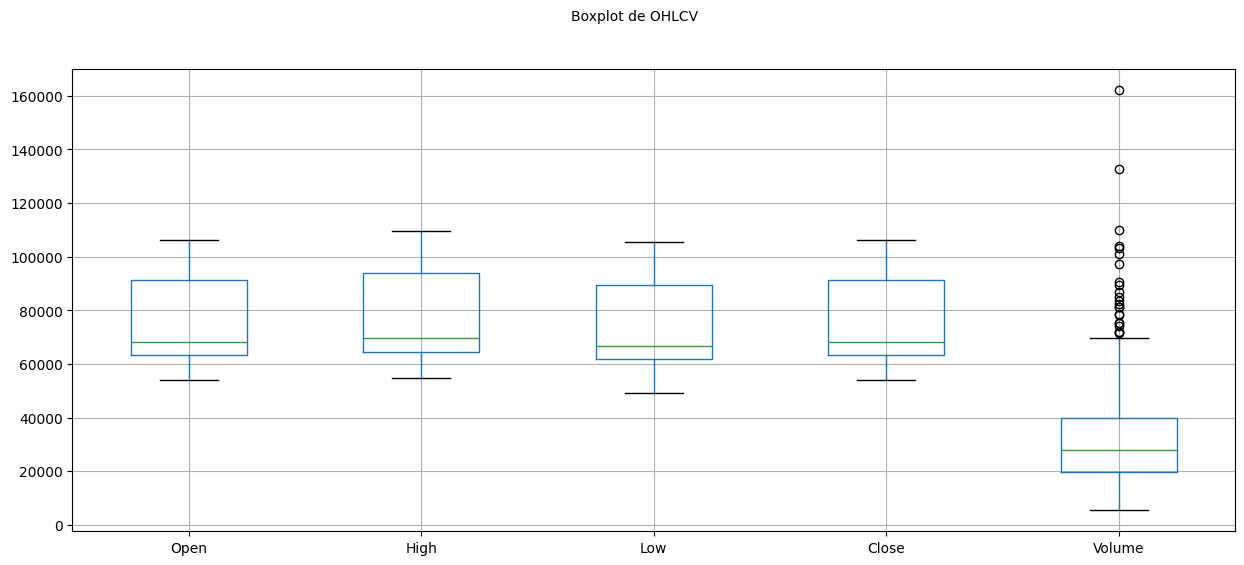

In [12]:
# Chequear outliers
plt.figure(figsize=(15, 6))
plt.suptitle("Boxplot de OHLCV", fontsize=LABEL_FONTSIZE)
df.boxplot(column=["Open", "High", "Low", "Close", "Volume"], figsize=(15, 5))
plt.show()

> 📝 <em><font color='Gray'>Nota:</font></em> Se puede aplicar un filtro para eliminar los outliers. Esto se puede hacer utilizando el método `quantile()` para calcular los percentiles 0.01 y 0.99 y luego filtrando los datos para mantener solo aquellos que están dentro de este rango. Sin embargo, no queremos "gaps" en la serie (ya que habría que ver una política de imputación de datos), por lo que se trabajará con esta información.

Finalmente, guardamos el dataset en un archivo pickle que nos permite incorporar información extra como los tipos de las columnas para su posterior uso:

In [13]:
df.to_pickle(DATASET_PICKLE_FILE_PATH)

#### Visualización rápida

Se utiliza la librería `mplfinance` (también se puede utilizar la librería `datavizcatalogue`) para graficar y obtener una rápida visión de los datos. La función `plot_candlestick` permite visualizar las velas OHLC (Open, High, Low, Close) de los precios a lo largo del tiempo:

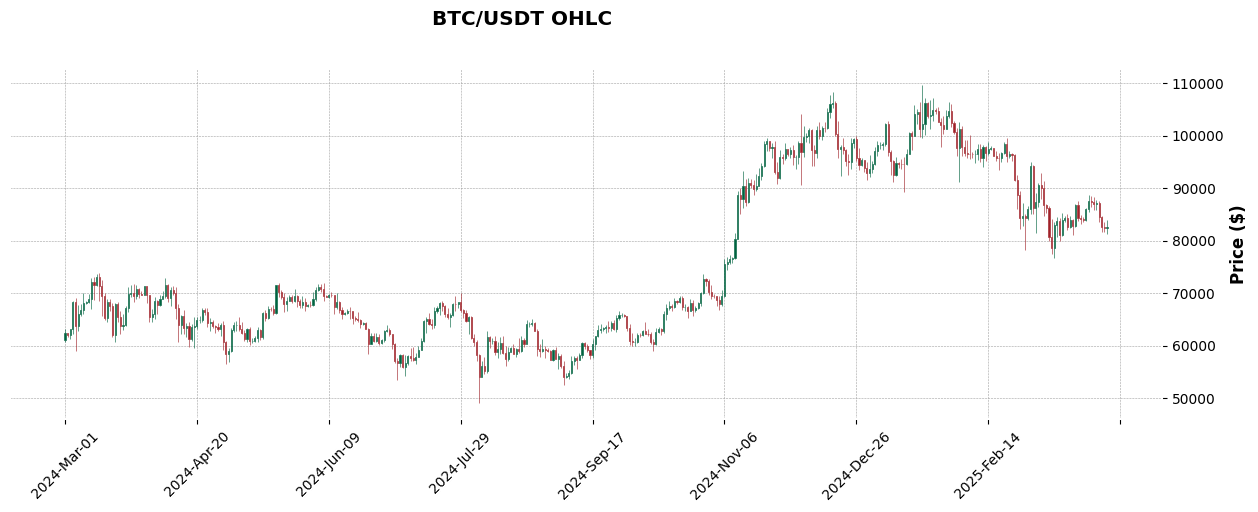

In [14]:
df_ohlc = df[[ "Open", "High", "Low", "Close"]].copy()

# Definimos el estilo del gráfico
style = mpf.make_mpf_style(base_mpf_style="charles", rc={"font.size": 10})

# Creamos el gráfico de velas
mpf.plot(df_ohlc, type="candle", style=style, title="BTC/USDT OHLC", ylabel="Price ($)", figsize=(16, 5))

#### Gráficos sobre las variables

Las variables de interés para resolver los objetivos específicos son el precio de cierre. Podemos realizar gráficos simples sobre esta variable para observar su comportamiento. También se muestra la relación que tiene con el volumen de operaciones.

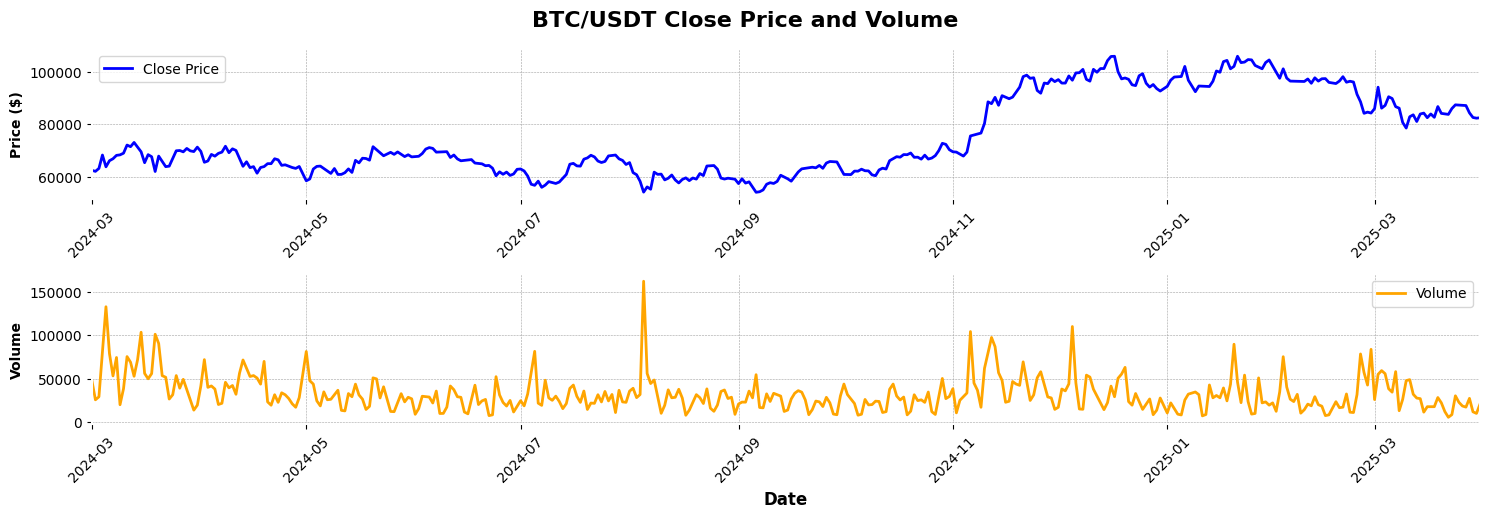

In [15]:
# Graficamos ambos precios y volumen en un solo gráfico
plt.figure(figsize=(15, 5))
plt.suptitle("BTC/USDT Close Price and Volume", fontsize=TITLE_FONTSIZE)

plt.subplot(2, 1, 1)
plt.plot(df["Close"], label="Close Price", color="blue")
plt.ylabel("Price ($)", fontsize=LABEL_FONTSIZE)
plt.autoscale(axis="x", tight=True)
plt.xticks(rotation=45)
plt.legend(fontsize=LABEL_FONTSIZE)

plt.subplot(2, 1, 2)
plt.plot(df["Volume"], label="Volume", color="orange")
plt.ylabel("Volume", fontsize=LABEL_FONTSIZE)
plt.autoscale(axis="x", tight=True)
plt.xticks(rotation=45)
plt.legend(fontsize=LABEL_FONTSIZE)
plt.tight_layout()

plt.xlabel("Date")

plt.show()

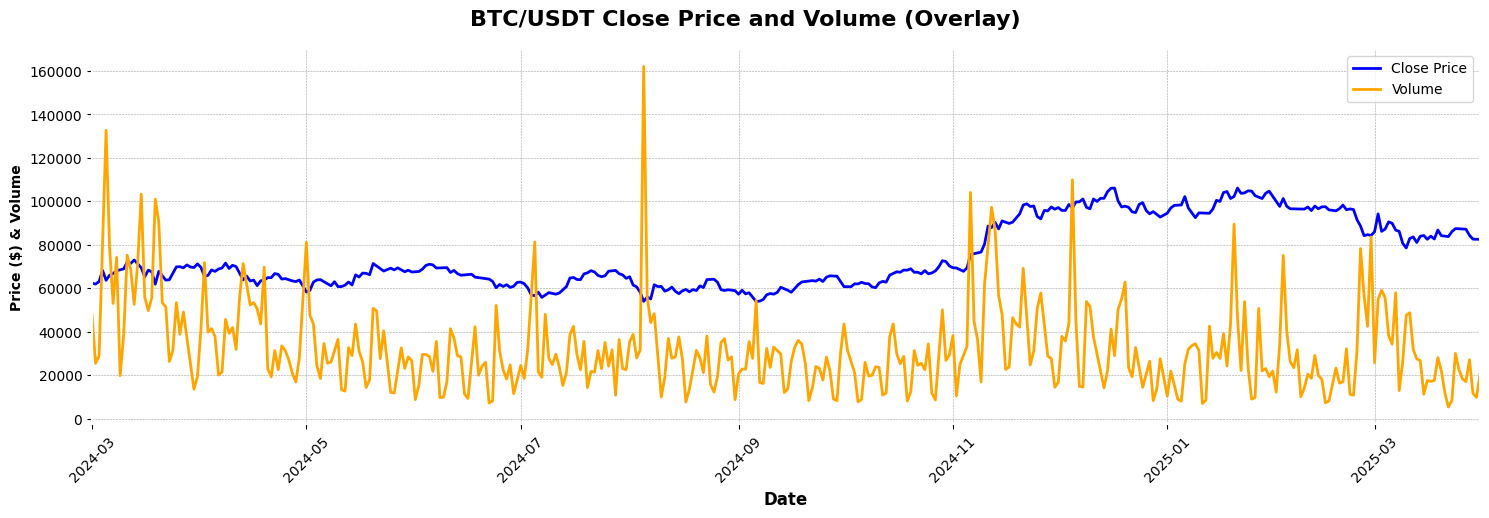

In [16]:
# Graficamos uno sobre el otro
plt.figure(figsize=(15, 5))
plt.suptitle("BTC/USDT Close Price and Volume (Overlay)", fontsize=TITLE_FONTSIZE)

plt.plot(df["Close"], label="Close Price", color="blue")
plt.plot(df["Volume"], label="Volume", color="orange")
plt.ylabel("Price ($) & Volume", fontsize=LABEL_FONTSIZE)
plt.autoscale(axis="x", tight=True)
plt.xticks(rotation=45)
plt.legend(fontsize=LABEL_FONTSIZE)
plt.tight_layout()
plt.xlabel("Date")

plt.show()

En los gráficos anteriores podemos observar que el volumen se mantiene casi constante (con un amplio ruido) a lo largo del tiempo, mientras que el precio de cierre presenta una tendencia creciente en el período estudiado. Esto sugiere que, a pesar de la estabilidad en el volumen de operaciones, el precio de BTCUSDT ha estado aumentando. En un principio, no parece haber una relación directa entre el volumen de operaciones y el precio de cierre, ya que los picos de volumen no siempre coinciden con picos en el precio en el período analizado. Sin embargo, se puede observar que desde el 11-2024 el volumen se ha vuelto más volátil y el precio a aumentado.

#### Descomposición ETS

La descomposición de la serie temporal es una técnica que permite la separar sus componentes principales: tendencia, estacionalidad y residuales. Podemos analizar esta descomposición para entender mejor el comportamiento del precio de cierre de la serie temporal y cómo se relacionan estas componentes entre sí. La descomposición se puede realizar utilizando la función `seasonal_decompose` de la librería `statsmodels`. Esta función permite descomponer la serie temporal en sus componentes principales y visualizar cada una de ellas por separado. Si nos enfocamos en el precio de cierre, obtenemos los siguientes resultados:

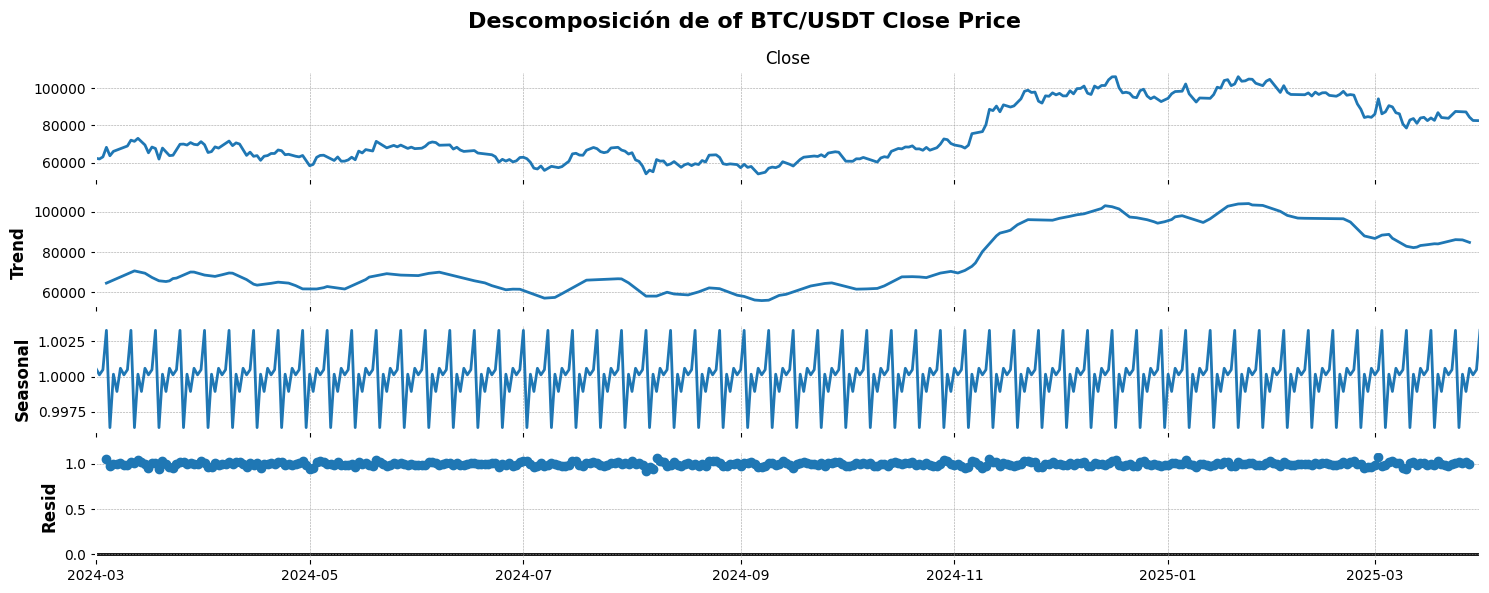

In [17]:
result = seasonal_decompose(df["Close"], model="multiplicative")
fig = result.plot()
fig.suptitle("Descomposición de of BTC/USDT Close Price", fontsize=TITLE_FONTSIZE)
fig.set_size_inches(15, 6)
fig.tight_layout()
plt.show()

En esta descomposición se puede observar claramente la tendencia alcista del precio de cierre luego del 11-2024. También se pueden observar uniformidad en la estacionalidad y el ruido, lo que sugiere que la serie temporal no presenta patrones estacionales claros.

#### Pruebas de estacionaridad

Los modelos auto regresivos y de media móvil son válidos cuando la serie es estacionaria, pues su fórmula y propiedades de inferencia asumen media y varianza constantes en el tiempo. El test de Dickey-Fuller aumentado (ADF) es una prueba estadística que se utiliza para determinar si una serie temporal es estacionaria o no. La hipótesis nula de la prueba ADF es que la serie temporal tiene una raíz unitaria, lo que indica que no es estacionaria. Si el valor p de la prueba es menor que un nivel de significancia (por ejemplo, $0.05$), se rechaza la hipótesis nula y se concluye que la serie temporal es estacionaria. La función `adfuller` de la librería `statsmodels` se utiliza para realizar la prueba ADF. Esta función devuelve varios valores, incluyendo el estadístico de la prueba y el valor $p$. Inicialmente, se realiza una prueba de estacionaridad sobre la variable objetivo (precio de cierre):

In [18]:
result = sts.adfuller(df["Close"])
print(f"Estadístico ADF: {result[0]}")
print(f"Valor p: {result[1]}")
print(f"Valores críticos: {result[4]}")

Estadístico ADF: -1.420856101366877
Valor p: 0.5722376131152292
Valores críticos: {'1%': -3.447014064067954, '5%': -2.8688850015516016, '10%': -2.5706826870693797}


En este caso podemos observar que el valor de $p$ es mayor que $0.05$, lo que indica que no podemos rechazar la hipótesis nula y, por lo tanto, la serie temporal no es estacionaria.

Sin embargo, esto no implica que no podemos realizar un análisis de series temporales. Existen técnicas para transformar la serie temporal en una serie estacionaria, como la diferenciación o la transformación logarítmica. La diferenciación consiste en calcular la diferencia entre los valores de la serie temporal en diferentes momentos en el tiempo. Esto puede ayudar a eliminar tendencias y estacionalidades, haciendo que la serie sea más estacionaria.

Para verificar si esta técnica nos permite obtener una serie estacionaria realizamos nuevamente el test ADF sobre la serie diferenciada.

In [19]:
result = sts.adfuller(df["Close"].diff().dropna())
print(f"Estadístico ADF: {result[0]}")
print(f"Valor p: {result[1]}")
print(f"Valores críticos: {result[4]}")

Estadístico ADF: -21.412563900673952
Valor p: 0.0
Valores críticos: {'1%': -3.4470566389664703, '5%': -2.8689037160476016, '10%': -2.570692663557422}


Observamos que la serie de tiempo diferenciada es estacionario. Esto es importante en cuanto nos permite aplicar modelos como los autorregresivos o de media móvil que asumen estacionaridad.

#### Autocorrelation y autocorrelación parcial

La función `plot_acf` y `plot_pacf` de la librería `statsmodels` se utilizan para graficar los correlogramas ACF y PACF, respectivamente. Estos gráficos nos permiten observar la correlación entre los valores de la serie temporal en diferentes momentos en el tiempo y determinar el orden de diferenciación necesario para hacer la serie estacionaria.

<u>Autocorrelación</u>:

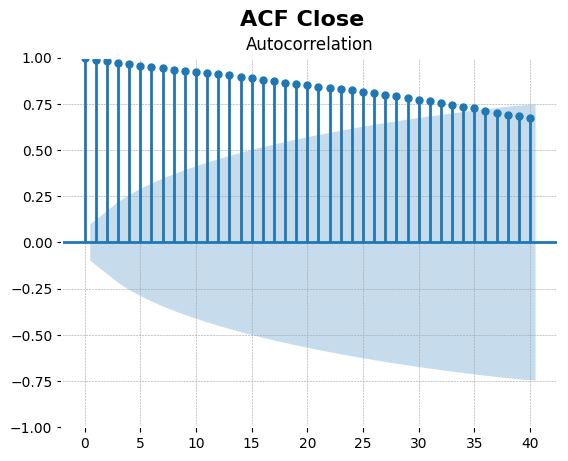

In [20]:
result = sgt.plot_acf(df["Close"], lags=40)
plt.suptitle("ACF Close", fontsize=TITLE_FONTSIZE)
plt.show()

La autocorrelación permite determinar el valor de $q$ en modelos de media movil $MA(q)$. En esta gráfica podemos observar que todos los rezagos son estadísticamente significativos, hasta el 35 aproximadamente.

<u>Autocorrelación parcial</u>:

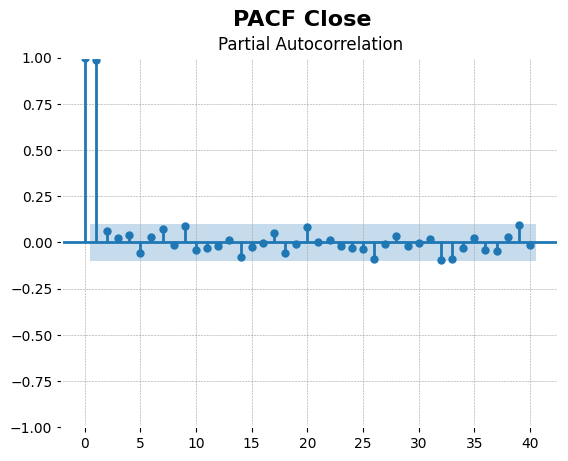

In [21]:
sgt.plot_pacf(df["Close"], lags=40)
plt.suptitle("PACF Close", fontsize=TITLE_FONTSIZE)
plt.show()

La autocorrelación parcial permite determinar el valor inicial de $p$ que se utiliza en los modelos auto regresivos $AR(p)$. Este valor indica el rezago significante más grande luego del cual la mayoría de los rezagos se vuelven insignificantes. En el gráfico de autocorrelación parcial, podemos observar que unicamente el rezago 1 es estadísticamente significativo.

Podemos suavizar la serie original para identificar tendencias con el valor encontrado (por ejemplo, con una ventana de 35 períodos):

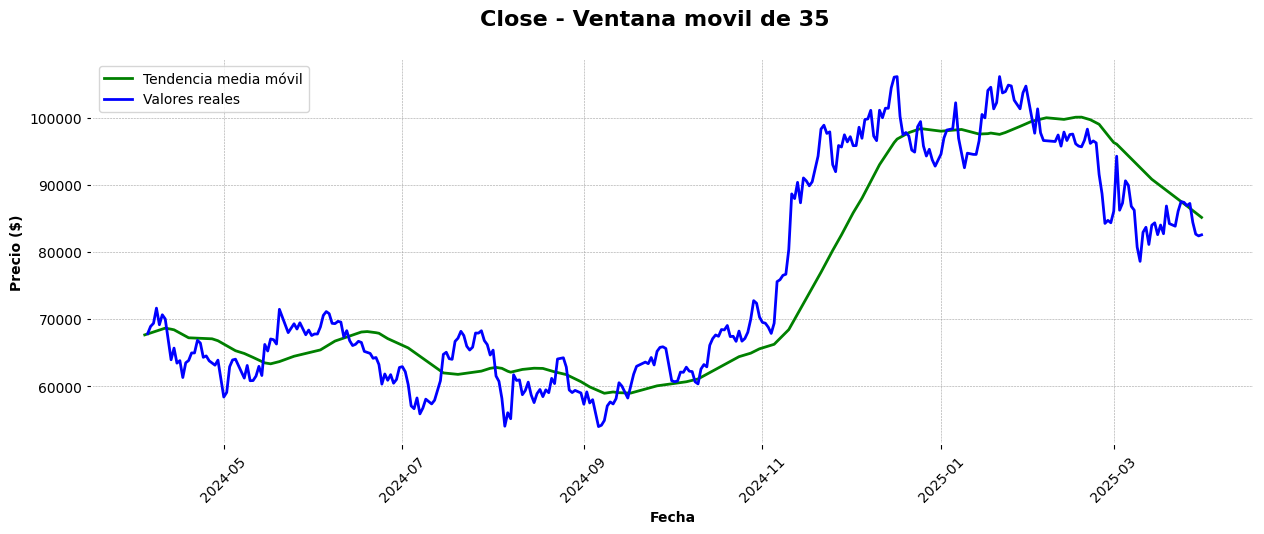

In [22]:
window = 35
rolling_mean = df["Close"].rolling(window=window).mean()

plt.figure(figsize=(15, 5))
plt.suptitle("Close - Ventana movil de {}".format(window), fontsize=TITLE_FONTSIZE)

plt.plot(rolling_mean, label="Tendencia media móvil", color="green")
plt.plot(df["Close"][window:], label="Valores reales", color="blue")
plt.xticks(rotation=45)
plt.xlabel("Fecha", fontsize=LABEL_FONTSIZE)
plt.ylabel("Precio ($)", fontsize=LABEL_FONTSIZE)
plt.legend(loc="best")
plt.grid(True)
plt.show()

Se puede observar que hay una tendencia hacia abajo para los próximos valores a corto plazo, sin embargo, dado los resultados de las pruebas y la forma de la gráfica, es muy difícil realizar una estimación a largo plazo. Se prevé que los modelos ARMA no sean efectivos para predecir el comportamiento de la serie temporal sin realizar diferenciaciones de la misma, ya que la serie no es estacionaria. En la siguiente sección se analizan varios tipos de modelos.

### Modelos de series temporales <a class="anchor" id="modelos-de-series-temporales"></a>

Creación de train y test sets:

In [23]:
df_models = pd.DataFrame()
df_models["ds"] = df["Close Time"].dt.date.copy()
df_models["y"] = df["Close"].copy()

# Split into initial train set (for rolling forecasting) and test set
split_index = int(len(df_models) * 0.80)

initial_train = df_models.iloc[:split_index].copy()
test_set = df_models.iloc[split_index:].copy()

Creación de utilidades para comparar los modelos

In [24]:



def evaluate_model(y_true, y_pred, model_name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    rmse = root_mean_squared_error(y_true, y_pred)

    return {"model": model_name, "mae": mae, "mape": mape, "rmse": rmse}

In [25]:
# List to store results
metrics_list = []

**Baseline (Naive model)**

A modo de *baseline* predecimos siempre el precio del día anterior. Esto quiere decir que los modelos de series de tiempo que entrenemos a continuación deberían mostrar una performance mayor a la de esta heurística para probar su potencial de forecasting.

In [26]:
# Baseline: naive forecasting
naive_test_set = df_models.iloc[split_index - 1:].copy() # add last training day to forecast first test day

y_pred = naive_test_set["y"][1:]
y_test = naive_test_set["y"].shift(1)[1:]

metrics = evaluate_model(y_test, y_pred, model_name="Naive")
metrics_list.append(metrics)

print(f"MAE: {metrics['mae']:.1f}")
print(f"MAPE: {metrics['mape']:.4f}")
print(f"RMSE: {metrics['rmse']:.1f}")

MAE: 1735.7
MAPE: 1.8886
RMSE: 2434.5


#### **ARIMA**

En base al análsis anterior, concluimos que la serie diferenciada una vez es estacionaria. Vamos entonces a aplicar un modelo $ARIMA$ con parámetros $(p=1, d=1, q=35)$, esto es cantidad de coeficientes $AR$, numero de diferenciaciones iterativas, y cantidad de coeficientes $MA$ respectivamente.

In [27]:
# Usar la columna "Close"
data = df["Close"]

# Definir el punto de corte (80% train, 20% test)
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Entrenar ARIMA(35,1,1) en el set de entrenamiento
model = ARIMA(train, order=(1, 1, 35))
model_fit = model.fit()

# Resumen del modelo entrenado
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  316
Model:                ARIMA(1, 1, 35)   Log Likelihood               -2809.617
Date:                Sat, 07 Jun 2025   AIC                           5693.233
Time:                        18:37:51   BIC                           5832.078
Sample:                    03-01-2024   HQIC                          5748.707
                         - 01-10-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0997     23.587     -0.004      0.997     -46.329      46.129
ma.L1          0.0904     23.593      0.004      0.997     -46.152      46.332
ma.L2          0.0217      0.220      0.099      0.9

Se observa que ninguno de los coeficientes $AR$ y $MA$ son significativamente diferentes de $0$. Incluso, la mayor parte de ellos presentan un P-valor cercano a 1 dando cuenta de que son altamente insignificantes.

In [28]:
# Inicializar la historia con el set de entrenamiento
history = train.copy()
predictions = []

# Hacer predicciones paso a paso con valores reales
for t in range(len(test)):
    pred = model_fit.apply(history).forecast()[0]
    predictions.append(pred)
    history = pd.concat([history, pd.Series([test.iloc[t]], index=[test.index[t]])])

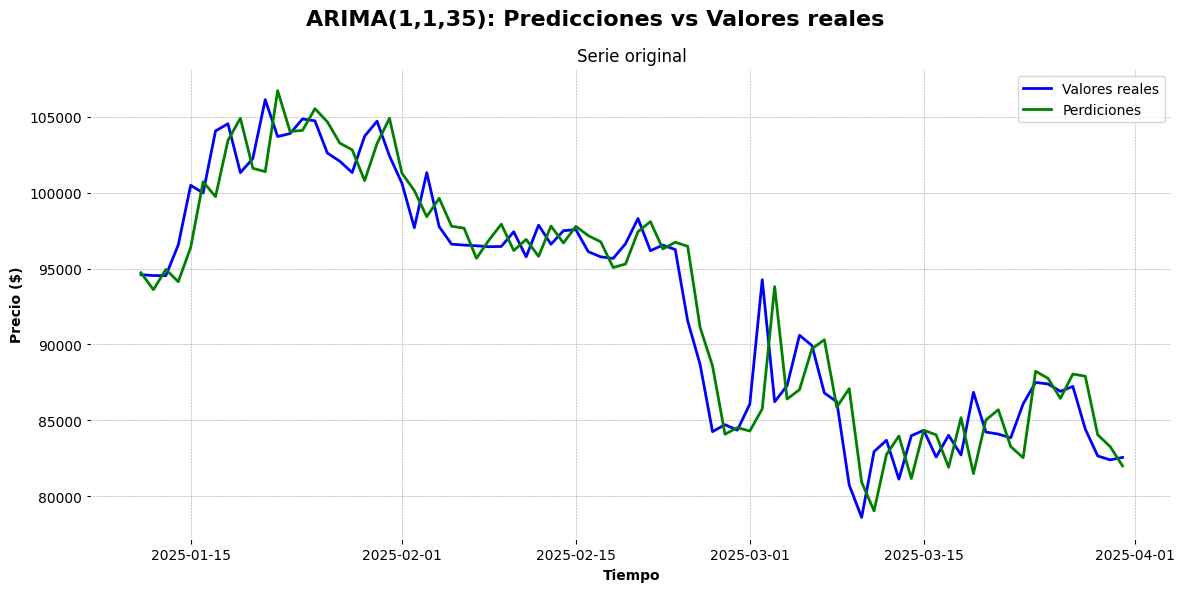

In [29]:
# --- Gráfico de predicción vs realidad ---
plt.figure(figsize=(12,6))
plt.plot(test.index, test.values, label="Valores reales", color="b")
plt.plot(test.index, predictions, label="Perdiciones", color="g")

plt.suptitle("ARIMA(1,1,35): Predicciones vs Valores reales", fontsize=TITLE_FONTSIZE)
plt.title("Serie original")
plt.xlabel("Tiempo", fontsize=LABEL_FONTSIZE)
plt.ylabel("Precio ($)", fontsize=LABEL_FONTSIZE)
plt.legend(loc="best")
plt.tight_layout()
plt.grid(True)
plt.show()

In [30]:
metrics = evaluate_model(test, predictions, model_name="ARIMA(1,1,35)")
metrics_list.append(metrics)

print(f"MAE: {metrics['mae']:.1f}")
print(f"MAPE: {metrics['mape']:.4f}")
print(f"RMSE: {metrics['rmse']:.1f}")

MAE: 1891.7
MAPE: 2.0636
RMSE: 2546.3


Se observa que el comportamiento de las predicciones del modelo sigue un patrón similar a los valores de test, pero desfasado por un día. Esto es una señal de alarma, ya que el objetivo es que el modelo ayude al usuario a tomar la decisión de si conviene vender o comprar al inicio del día en función del precio estimado para el día siguiente.

**Libreria autoarima**

La librería autoarima permite automatizar el proceso de selección del mejor modelo de la familia $ARIMA$ testeando diferentes combinaciones de parámetros $(p, d, q)$ y eligiendo aquel que minimiza el criterio elegido, siendo AIC el predeterminado. Anteriormente elegimos los parámetros de nuestro modelo en función de un análisis de significancia mediante los gráficos ACF y PACF. La utilización de la librería autoarima nos permitirá validar o no nuestra elección anterior.

In [31]:
# Get best ARIMA model structure
initial_model = auto_arima(initial_train['y'],
                           start_p=0, max_p=5,         # AR terms to try
                           start_q=0, max_q=40,        # MA terms to try
                           d = None,                   # Auto-detect d
                           seasonal=False, trace=True,
                           suppress_warnings=True, error_action='ignore')

# Extract best order
best_order = initial_model.order
print("Best ARIMA order:", best_order)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5669.513, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5670.958, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5671.116, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5668.389, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5672.390, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.125 seconds
Best ARIMA order: (0, 1, 0)


Es interesante notar que el modelo de la familia ARIMA que mejor performa es ARIMA(0,1,0)(0,0,0), es decir un modelo diferenciado de primer orden sin componentes autorregresivos ni de media movil. Nuestro modelo es entonces:

$$\Delta Y_t = Y_t - Y_{t-1} = \epsilon_t$$ 

Por lo que la serie diferenciada (el retorno) se modela como ruido blanco.

Al reorganizar la ecuación tenemos:

$$Y_t = Y_{t-1} + \epsilon_t$$

El valor actual de la serie de tiempo original entonces es igual al anterior más ruido blanco, es decir a una caminata aleatoria. Por lo que la predicción para el dia siguiente bajo este modelo es el valor actual (más ruido no modelable), es decir el modelo naive utilizado como baseline.

A continuación realizamos el loop de entrenamiento y predicción para comprobar que nuestras deducciones son correctas.

In [32]:
predictions = []
actuals = []
forecast_dates = []

rolling_train = initial_train.copy()

# Loop through each day in the test set
for i in tqdm(range(len(test_set))):
    next_day = test_set.iloc[i]["ds"]

    # Train ARIMA with fixed order on updated rolling_train
    model = ARIMA(rolling_train["y"], order=best_order)
    model_fit = model.fit()

    # Predict next day value
    yhat = model_fit.forecast()[0]
    ytrue = test_set.iloc[i]["y"]

    predictions.append(yhat)
    actuals.append(ytrue)
    forecast_dates.append(next_day)

    # Append next day to training set (simulate rolling forward)
    rolling_train = pd.concat([rolling_train, test_set.iloc[[i]]])


  0%|          | 0/80 [00:00<?, ?it/s]

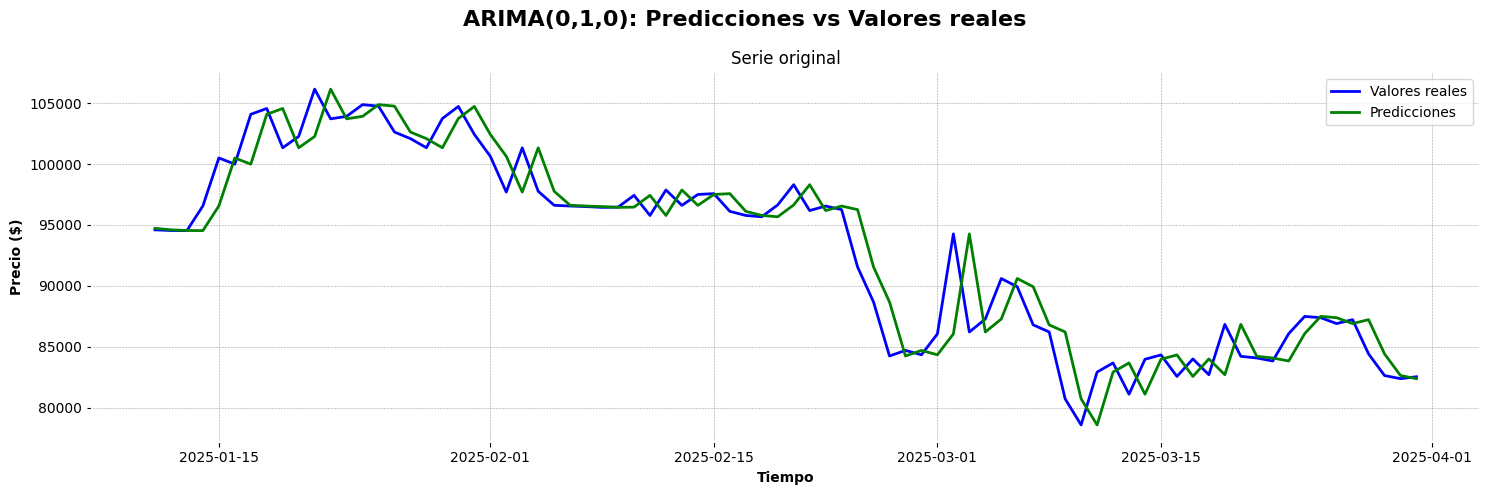

In [33]:
results = pd.DataFrame({
    'ds': forecast_dates,
    'yhat': predictions,
    'ytrue': actuals
})

plt.figure(figsize=(15, 5))
plt.plot(results['ds'], results['ytrue'], label="Valores reales", color="b")
plt.plot(results['ds'], results['yhat'], label="Predicciones", color="g")
plt.suptitle("ARIMA(0,1,0): Predicciones vs Valores reales", fontsize=TITLE_FONTSIZE)
plt.title("Serie original")
plt.xlabel("Tiempo", fontsize=LABEL_FONTSIZE)
plt.ylabel("Precio ($)", fontsize=LABEL_FONTSIZE)
plt.legend(loc="best")
plt.tight_layout()
plt.grid(True)
plt.show()

In [34]:
metrics = evaluate_model(results["ytrue"], results["yhat"], model_name="ARIMA(0,1,0)")
metrics_list.append(metrics)

print(f"MAE: {metrics['mae']:.1f}")
print(f"MAPE: {metrics['mape']:.4f}")
print(f"RMSE: {metrics['rmse']:.1f}")

MAE: 1735.7
MAPE: 1.8945
RMSE: 2434.5


Efectivamente, observamos que el Mean Absolute Percentage Error obtenido es el mismo que el obtenido con el modelo baseline. Este resultado permite comprobar empíricamente que un modelo $ARIMA(0,1,0)$ a fines prácticos predice lo mismo que un modelo naive (cada dia predice un valor igual que el observado el dia anterior).

#### **Prophet**

**Prophet** es un modelo open source desarrollado por Facebook, diseñado para la predicción de series temporales. Este modelo se basa en una descomposición aditiva de la serie en tres componentes principales: **tendencia, estacionalidad y festivos o eventos especiales**.

En primer lugar, en lo que respecta a la **componente de tendencia**, Prophet es capaz de detectar cambios estructurales introduciendo automáticamente puntos de cambio (changepoints) a lo largo de la serie temporal. Durante el entrenamiento, se aplican técnicas de regularización L1 para determinar cuáles de estos puntos son realmente significativos. Esta estrategia permite al modelo modificar la pendiente de la tendencia cuando se producen cambios relevantes en el comportamiento de la serie. Además, el usuario puede incorporar manualmente puntos de cambio basados en conocimiento del dominio, como por ejemplo el inicio de una campaña de marketing o la implementación de una nueva política empresarial.

Por otro lado, Prophet ofrece soporte integrado para múltiples patrones de **estacionalidad**, como los ciclos diarios, semanales o anuales. También es posible definir patrones personalizados, lo que resulta especialmente útil en contextos donde se observan comportamientos periódicos predecibles, como ocurre frecuentemente en los datos de redes sociales o en entornos comerciales.

Finalmente, el modelo permite incluir **festivos o eventos recurrentes**, los cuales ayudan a capturar efectos temporales no estacionales que puedan generar anomalías o picos de actividad. En el caso del comercio electrónico, por ejemplo, esto puede incluir fechas clave como Black Friday o Cyber Monday. Durante la etapa de pronóstico (forecasting), el usuario puede volver a introducir estos eventos usando el mismo identificador utilizado durante el entrenamiento, lo que permite que el modelo incorpore su impacto en la predicción futura.

In [35]:
# Wrapper function to create prophet instance.
# Includes hyperparameters options for tuning.
def create_prophet_model():
    m = Prophet(
        growth='linear',
        changepoint_range=0.8,
        changepoint_prior_scale=0.05,
        seasonality_mode='additive',
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False   
    )

    # Add custom seasonality patter (optional)
    # m.add_seasonality(
    #     name='crypto_cycle',
    #     period=3,             # 3-day cycle (adjust accordingly)
    #     fourier_order=5       # seasonal patter complexity
    # )

    return m

In [36]:
predictions = []
actuals = []
forecast_dates = []

rolling_train = initial_train.copy()

# Loop through each day in the test set
for i in tqdm(range(len(test_set))):
    next_day = test_set.iloc[i]["ds"]

    # Fit model using all data up to current day
    model = create_prophet_model()
    model.fit(rolling_train)

    # Predict next day value
    future = pd.DataFrame({'ds': [next_day]})
    forecast = model.predict(future)

    # Store forecasted and actual values
    yhat = forecast["yhat"].values[0]
    ytrue = test_set.iloc[i]["y"]
    
    predictions.append(yhat)
    actuals.append(ytrue)
    forecast_dates.append(next_day)

    # Append next day to training set (simulate rolling forward)
    rolling_train = pd.concat([rolling_train, test_set.iloc[[i]]])

  0%|          | 0/80 [00:00<?, ?it/s]

18:37:55 - cmdstanpy - INFO - Chain [1] start processing
18:37:55 - cmdstanpy - INFO - Chain [1] done processing
18:37:55 - cmdstanpy - INFO - Chain [1] start processing
18:37:55 - cmdstanpy - INFO - Chain [1] done processing
18:37:55 - cmdstanpy - INFO - Chain [1] start processing
18:37:55 - cmdstanpy - INFO - Chain [1] done processing
18:37:56 - cmdstanpy - INFO - Chain [1] start processing
18:37:56 - cmdstanpy - INFO - Chain [1] done processing
18:37:56 - cmdstanpy - INFO - Chain [1] start processing
18:37:56 - cmdstanpy - INFO - Chain [1] done processing
18:37:56 - cmdstanpy - INFO - Chain [1] start processing
18:37:56 - cmdstanpy - INFO - Chain [1] done processing
18:37:56 - cmdstanpy - INFO - Chain [1] start processing
18:37:56 - cmdstanpy - INFO - Chain [1] done processing
18:37:56 - cmdstanpy - INFO - Chain [1] start processing
18:37:56 - cmdstanpy - INFO - Chain [1] done processing
18:37:56 - cmdstanpy - INFO - Chain [1] start processing
18:37:56 - cmdstanpy - INFO - Chain [1]

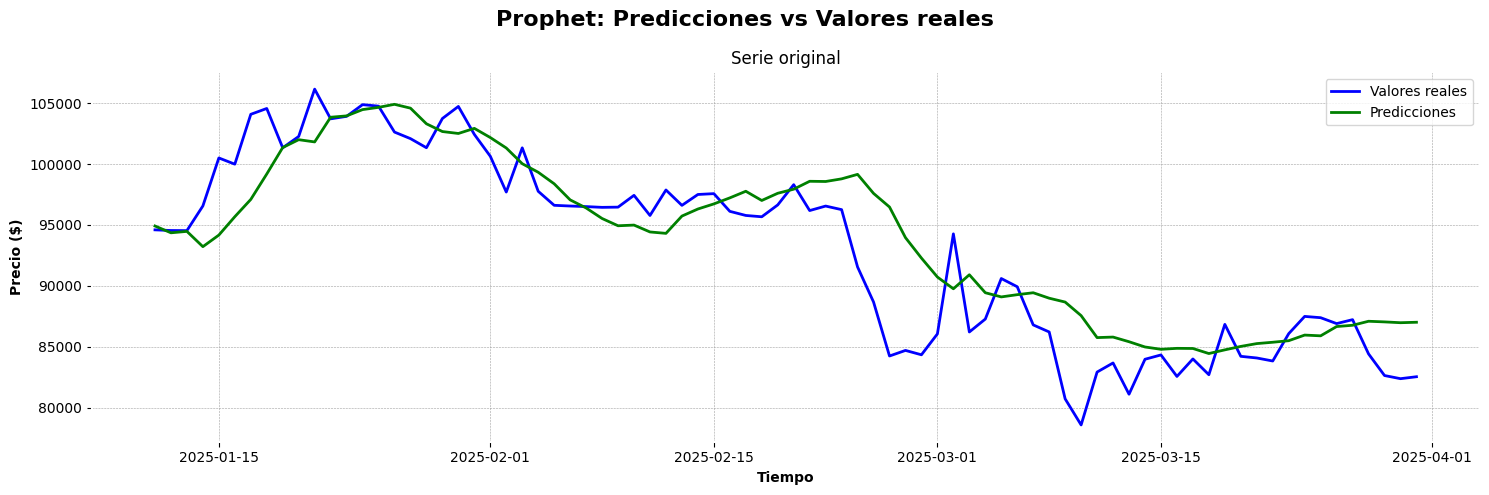

In [37]:
results = pd.DataFrame({
    'ds': forecast_dates,
    'yhat': predictions,
    'ytrue': actuals
})

plt.figure(figsize=(15, 5))
plt.plot(results['ds'], results['ytrue'], label="Valores reales", color="blue")
plt.plot(results['ds'], results['yhat'], label="Predicciones", color="green")
plt.suptitle("Prophet: Predicciones vs Valores reales", fontsize=TITLE_FONTSIZE)
plt.title("Serie original")
plt.xlabel("Tiempo", fontsize=LABEL_FONTSIZE)
plt.ylabel("Precio ($)", fontsize=LABEL_FONTSIZE)
plt.legend(loc="best")
plt.tight_layout()
plt.grid(True)
plt.show()

In [38]:
metrics = evaluate_model(results["ytrue"], results["yhat"], model_name="Prophet")
metrics_list.append(metrics)

print(f"MAE: {metrics['mae']:.1f}")
print(f"MAPE: {metrics['mape']:.4f}")
print(f"RMSE: {metrics['rmse']:.1f}")

MAE: 2582.6
MAPE: 2.8714
RMSE: 3621.7


Se observa que las predicciones realizadas con prophet son considerablemente inferiores que el baseline de predecir siempre lo mismo que el día anterior. Si bien Prophet es un modelo que suele dar buenos resultados en series con una marcada tendencia y estacionalidad, como pueden ser ventas minoristas, tráfico, o reservas, no da buenos resultados en series tan volátiles y con falta de tendencia a corto plazo como son las criptomonedas.

El baseline, por otro lado, otorga mejores resultados en predicciónes de precios financieros ya que a corto plazo actúan similar a caminatas aleatorias. Prophet, a diferencia del modelo naive o de los modelos autorregresivos, no utiliza $Y_{t-k}$ para predecir un nuevo valor, sino que modela la tendencia, la estacionalidad, y los festivos recurrentes de la serie. En este sentido, las tendencias de los cambios de precio en cryptos suelen ser no lineares y con cambios abruptos, comportamientos que Prophet no captura bien.

#### **XGBoost**

XGBoost no es un modelo de series temporales, sino un modelo de regresión. Por lo tanto, no se puede utilizar directamente para predecir el comportamiento de la serie temporal. Sin embargo, se puede utilizar como un modelo de regresión para predecir el precio de cierre en función de otras variables, como el volumen de operaciones y los rezagos del precio de cierre.

<u>Carga de datos:</u>

In [39]:
# Cargamos el conjunto de datos con el formato correcto
df = pd.read_pickle(DATASET_PICKLE_FILE_PATH)

<u>Análisis de datos + ingeniería de características:</u>

Nos quedamos solamente con el precio de cierre y creamos 35 rezagos como características, también algunas medias móviles para ver si podemos predecir el precio de cierre en función de estas características. Luego, realizamos el análisis tanto para la serie original como para la serie diferenciada.

In [40]:
# Nos quedamos con el precio de cierre
df = df[["Close"]]

# Renombramos la columna "Close" a "y"
df.rename(columns={"Close": "y"}, inplace=True)

# Creamos la serie diferenciada
df_delta = df.copy().diff().dropna()

# Creamos los rezagos para ambas series
for i in range(1, 35):
    df["rezago_{}".format(i)] = df.y.shift(i)
    df_delta["rezago_{}".format(i)] = df_delta.y.shift(i)

# Agregamos las medias móviles para ambas series
for window in [3, 7, 14]:
    df[f'rolling_mean_{window}'] = df['y'].rolling(window=window).mean()
    df_delta[f'rolling_mean_{window}'] = df_delta['y'].rolling(window=window).mean()

# Eliminamos los valores NaN generados por los rezagos
df.dropna(inplace=True)
df_delta.dropna(inplace=True)

print(f"Cantidad de filas: {len(df)}")
print(f"Cantidad de filas: {len(df_delta)}")

df.head()

Cantidad de filas: 362
Cantidad de filas: 361


,y,rezago_1,rezago_2,rezago_3,rezago_4,rezago_5,rezago_6,rezago_7,rezago_8,rezago_9,...,rezago_28,rezago_29,rezago_30,rezago_31,rezago_32,rezago_33,rezago_34,rolling_mean_3,rolling_mean_7,rolling_mean_14
Open Time,,,,,,,,,,,,,,,,,,,,,
2024-04-04,68487.79,65963.28,65463.99,69649.80,71280.01,69582.18,69850.54,70780.60,69469.99,69988.00,...,66823.17,66074.04,63724.01,68245.71,63113.97,61987.28,62387.90,66638.353333,68611.084286,68242.345000
2024-04-05,67820.62,68487.79,65963.28,65463.99,69649.80,71280.01,69582.18,69850.54,70780.60,69469.99,...,68124.19,66823.17,66074.04,63724.01,68245.71,63113.97,61987.28,67423.896667,68321.095714,68529.772143
2024-04-06,68896.00,67820.62,68487.79,65963.28,65463.99,69649.80,71280.01,69582.18,69850.54,70780.60,...,68313.27,68124.19,66823.17,66074.04,63724.01,68245.71,63113.97,68401.470000,68223.070000,68880.200000
2024-04-07,69360.39,68896.00,67820.62,68487.79,65963.28,65463.99,69649.80,71280.01,69582.18,69850.54,...,68955.88,68313.27,68124.19,66823.17,66074.04,63724.01,68245.71,68692.336667,67948.838571,69033.800000
2024-04-08,71620.00,69360.39,68896.00,67820.62,68487.79,65963.28,65463.99,69649.80,71280.01,69582.18,...,72078.10,68955.88,68313.27,68124.19,66823.17,66074.04,63724.01,69958.796667,68230.295714,69158.085000


<u>Modelado:</u>

Definimos funciones auxiliares para dividir y graficar los datos:

In [41]:
def timeseries_train_test_split(X, y, test_size):
    test_index = int(len(X) * (1 - test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test

**Serie original:**

In [42]:
y = df["y"]
X = df.drop(columns=["y"])

X_train, X_test, y_train, y_test = timeseries_train_test_split(
    X, y, test_size=0.2
)  # 80% train, 20% test

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

xgb = XGBRegressor(random_state=42, verbosity=0)
xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

<u>Predicciones:</u>

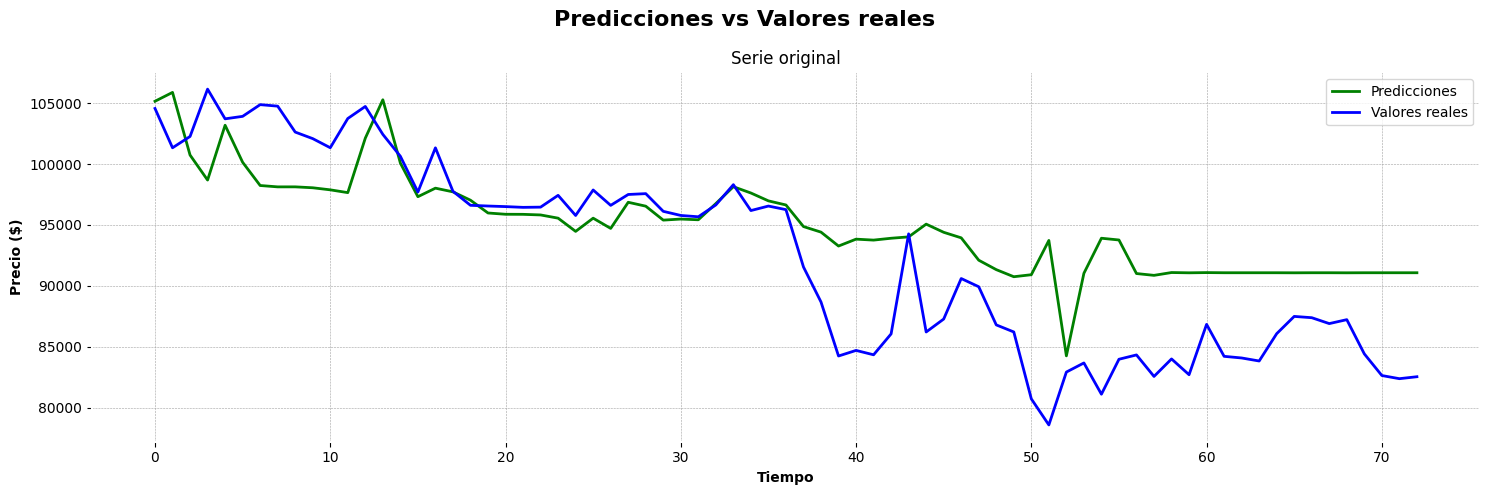

In [43]:
y_pred = xgb.predict(X_test_scaled)

plt.figure(figsize=(15, 5))
plt.plot(y_pred, label="Predicciones", color="green")
plt.plot(y_test.values, label="Valores reales", color="blue")
plt.suptitle("Predicciones vs Valores reales", fontsize=TITLE_FONTSIZE)
plt.title("Serie original")
plt.xlabel("Tiempo", fontsize=LABEL_FONTSIZE)
plt.ylabel("Precio ($)", fontsize=LABEL_FONTSIZE)
plt.legend(loc="best")
plt.tight_layout()
plt.grid(True)
plt.show()

<u>Resultados:</u>

In [44]:
metrics = evaluate_model(y_pred, y_test, model_name="XGBoost (ST original)")
metrics_list.append(metrics)

print(f"MAE: {metrics['mae']:.1f}")
print(f"MAPE: {metrics['mape']:.4f}")
print(f"RMSE: {metrics['rmse']:.1f}")

print(f"R2: {xgb.score(X_test_scaled, y_test)}")

MAE: 4319.0
MAPE: 4.6093
RMSE: 5555.3
R2: 0.4938462833874311


**Serie diferenciada:**

In [45]:
y = df_delta["y"]
X = df_delta.drop(columns=["y"])

X_train, X_test, y_train, y_test = timeseries_train_test_split(
    X, y, test_size=0.2
)  # 80% train, 20% test

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

xgb = XGBRegressor(random_state=42, verbosity=0)
xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

<u>Predicciones:</u>

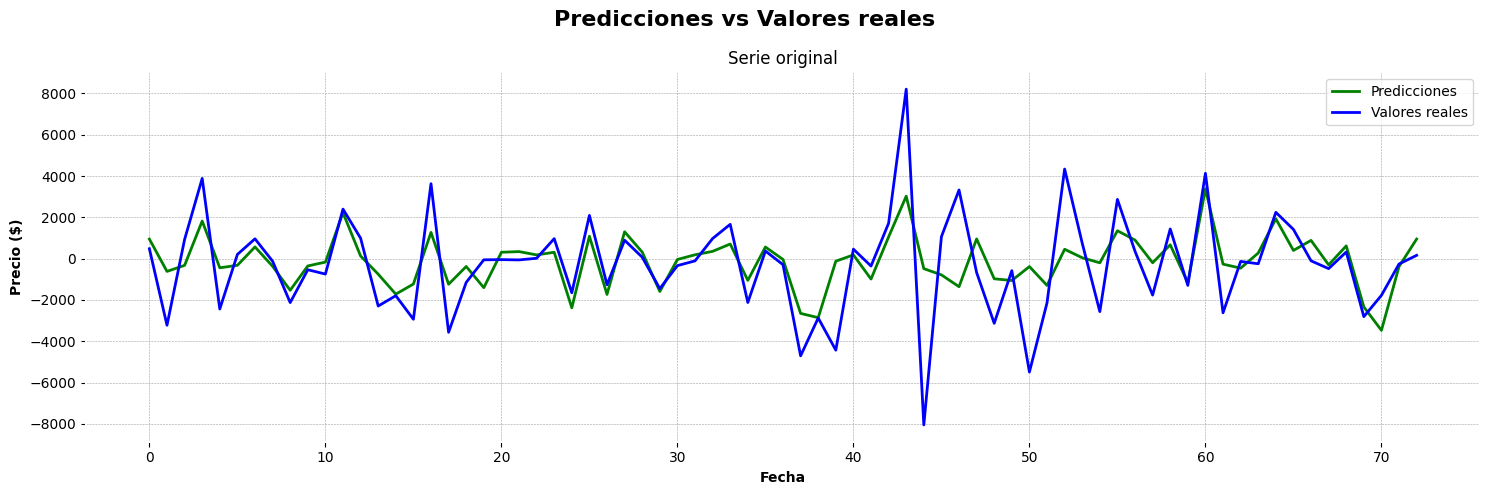

In [46]:
y_pred = xgb.predict(X_test_scaled)

plt.figure(figsize=(15, 5))
plt.plot(y_pred, label="Predicciones", color="green")
plt.plot(y_test.values, label="Valores reales", color="blue")
plt.suptitle("Predicciones vs Valores reales", fontsize=TITLE_FONTSIZE)
plt.title("Serie original")
plt.xlabel("Fecha", fontsize=LABEL_FONTSIZE)
plt.ylabel("Precio ($)", fontsize=LABEL_FONTSIZE)
plt.legend(loc="best")
plt.tight_layout()
plt.grid(True)
plt.show()

<u>Resultados:</u>

In [47]:
metrics = evaluate_model(y_pred, y_test, model_name="XGBoost (ST diferenciada)")
metrics_list.append(metrics)

print(f"MAE: {metrics['mae']:.1f}")
print(f"MAPE: {metrics['mape']:.4f}")
print(f"RMSE: {metrics['rmse']:.1f}")

print(f"R2: {xgb.score(X_test_scaled, y_test)}")

MAE: 1220.1
MAPE: 290.7838
RMSE: 1849.2
R2: 0.4210888795399247


Podemos observar que el modelo XGBoost tiene bajo performance dado los resultados obtenidos. Sin embargo, es importante tener en cuenta que el modelo no se ha ajustado adecuadamente y que se pueden realizar mejoras en el proceso de ajuste y selección de hiperparámetros.

#### **LSTM**

Las LSTM son un tipo de red neuronal diseñada para analizar datos secuenciales. Es especialmente buena para recordar detalles importantes durante periodos de tiempo. Esto la hace útil para predecir valores futuros en datos de series temporales, ya que puede identificar patrones complejos en los datos.

<u>Carga de datos:</u>

In [48]:
# Cargamos el conjunto de datos con el formato correcto
df = pd.read_pickle(DATASET_PICKLE_FILE_PATH)

<u>Analisis de datos + ingeniería de características:</u>

In [49]:
# Nos quedamos con el precio de cierre como una serie.
data = df['Close'].values
data = data.reshape(-1, 1)
print(f'Shape de los datos: {data.shape}')

Shape de los datos: (396, 1)


<u>Modelado</u>

Ahora, para la utilización de redes LSTM se espera que la entrada (recordando de NLP) sea una secuencia de $n$ valores en donde se quiere predecir el valor $n+1$. En este caso, se utilizará una ventana $w$, en donde dado el dato desde el tiempo $t-w$ hasta el tiempo $t$, se debe predecir el valor en el tiempo $t+1$ (para el caso de la arquitectura que crearemos *many-to-one*). El tamaño de la ventana indica cuantos datos miramos cuando queremos realizar una predicción. Para este caso, elegimos $w=35$, con lo que venimos trabajando. Para esto definimos una función que permite crear estas ventanas:

In [50]:
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i : i + time_steps, 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

Creamos las secuencias de datos para el modelo LSTM:

In [51]:
# Normalizamos los datos entre 0 y 1
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Utilizar una ventana de 35 días para predecir el precio del siguiente día
time_steps = 35
X, y = create_sequences(scaled_data, time_steps)
print(f'Shape de X: {X.shape}')
print(f'Shape de y: {y.shape}')

# Es necesario un reshape para la entrada de la LSTM (n_samples, time_steps, n_features)
X = X.reshape(X.shape[0], X.shape[1], 1) # Creo que se puede utilizar una función expand_dims de numpy para esto también.
print(f'Shape de X después del reshape: {X.shape}')

# Hacemos el spliting de los datos en train y test
# 80% para entrenamiento y 20% para test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print(f'Shapes (X_train, X_test, y_train, y_test): {X_train.shape, X_test.shape, y_train.shape, y_test.shape}') 

Shape de X: (361, 35)
Shape de y: (361,)
Shape de X después del reshape: (361, 35, 1)
Shapes (X_train, X_test, y_train, y_test): ((288, 35, 1), (73, 35, 1), (288,), (73,))


Definimos la arquitectura de la red LSTM (como prueba de concepto utilizamos una red simple):

In [52]:
model = Sequential()
model.add(Input(shape=(time_steps, 1))) # Capa de entrada
model.add(LSTM(50, return_sequences=False)) # Capa LSTM con 50 unidades
model.add(Dense(1)) # Capa de salida con una unidad (predicción del precio)

# Compilamos el modelo con adam y mse como función de pérdida
model.compile(optimizer="adam", loss="mean_squared_error")

Mostramos la arquitectura generada:

In [53]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Entrenamos el modelo en 20 épocas:

In [54]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1165 - val_loss: 0.0164
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0108 - val_loss: 0.0205
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0085 - val_loss: 0.0091
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0084 - val_loss: 0.0049
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0051 - val_loss: 0.0096
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0053 - val_loss: 0.0050
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0048 - val_loss: 0.0059
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0043 - val_loss: 0.0067
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0045 - val_loss: 0.0052
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0042 - val_loss: 0.0052
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0044 - val_loss: 0.0055
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0046 - val_loss: 0.0050
Epoch 13/20


Mostramos la gráfica de entrenamiento:

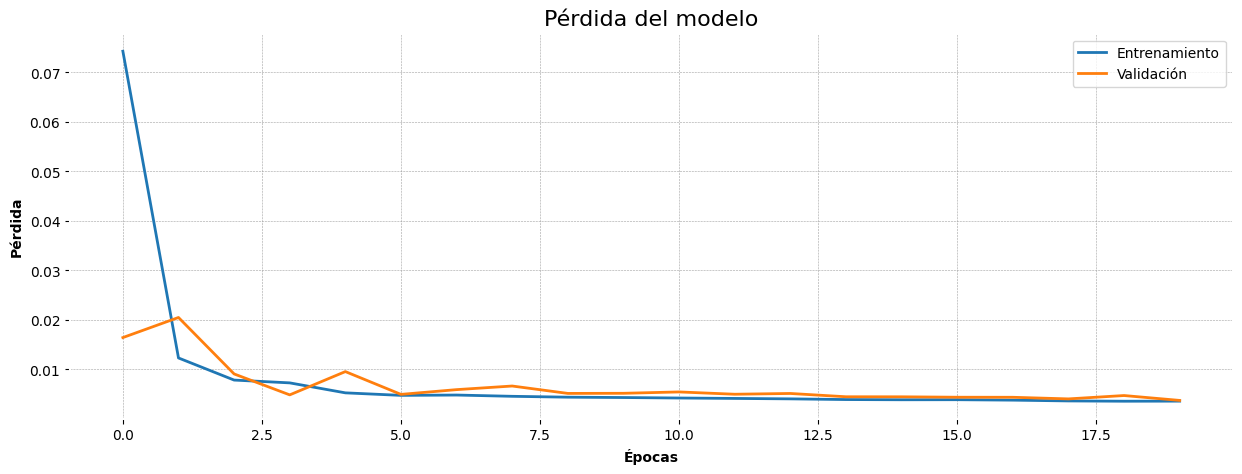

In [55]:
# Gráfica de entrenamiento y validación
plt.figure(figsize=(15, 5))
plt.plot(history.history["loss"], label="Entrenamiento")
plt.plot(history.history["val_loss"], label="Validación")
plt.title("Pérdida del modelo", fontsize=TITLE_FONTSIZE)
plt.xlabel("Épocas", fontsize=LABEL_FONTSIZE)
plt.ylabel("Pérdida", fontsize=LABEL_FONTSIZE)
plt.legend()
plt.show()

Podemos observar que el modelo ha convergido tanto en la función de pérdida como en validación, por lo que no se observa un sobreajuste. También se puede obseravar que luego de la época 10, la función de pérdida de validación se estabiliza, por lo que no sería necesario entrenar el modelo por más épocas.

<u>Predicciones:</u>

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


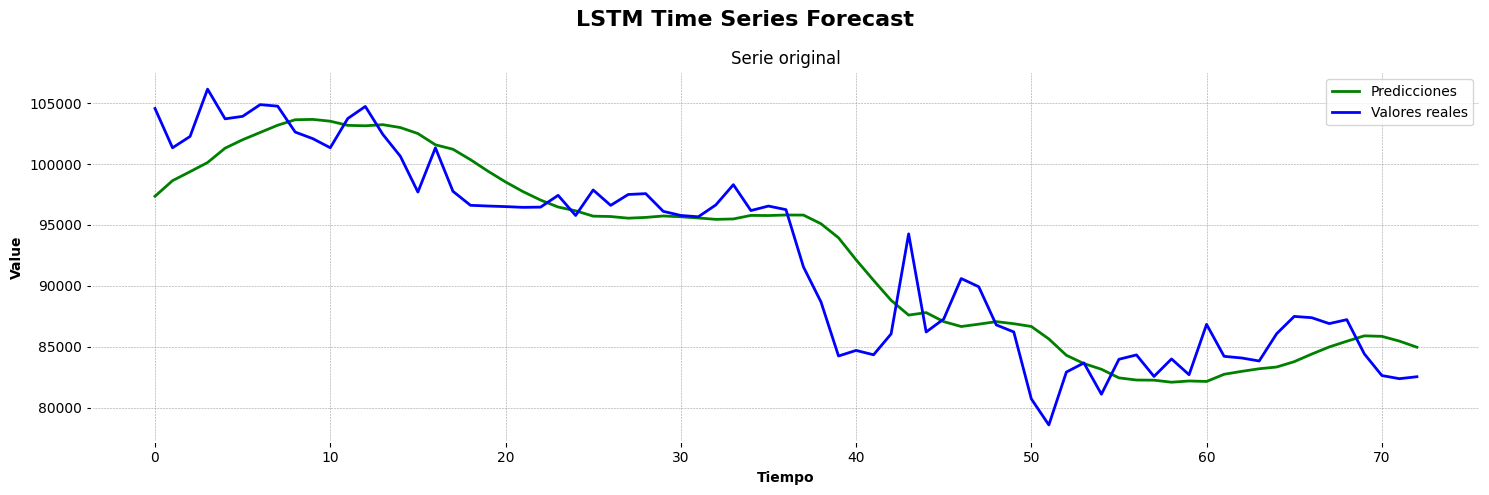

In [56]:
y_pred = model.predict(X_test)

# Aplicamos la inversa de la normalización a las predicciones y los valores reales (dado que le habíamos aplicado a todos los datos)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Graficamos los resultados
plt.figure(figsize=(15,5))
plt.plot(y_pred_rescaled, label='Predicciones', color='green')
plt.plot(y_test_rescaled, label='Valores reales', color='blue')
plt.suptitle('LSTM Time Series Forecast', fontsize=TITLE_FONTSIZE)
plt.title("Serie original")
plt.xlabel('Tiempo', fontsize=LABEL_FONTSIZE)
plt.ylabel('Value', fontsize=LABEL_FONTSIZE)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

<u>Resultados:</u>

In [57]:
metrics = evaluate_model(y_pred_rescaled, y_test_rescaled, model_name="LSTM")
metrics_list.append(metrics)

print(f"MAE: {metrics['mae']:.1f}")
print(f"MAPE: {metrics['mape']:.4f}")
print(f"RMSE: {metrics['rmse']:.1f}")

print(f"R2: {model.evaluate(X_test, y_test)}")

MAE: 2433.0
MAPE: 2.6451
RMSE: 3192.8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035 
R2: 0.0037438294384628534


En comparación con XGBoost, podemos observar que el modelo obtuvo mejores valores en todas las métricas. Tampoco hubo sobre ajuste, por lo que se podría intuir que es un mejor modelo (esto mirando la serie original).

### Conclusiones <a class="anchor" id="conclusiones"></a>

A lo largo del proyecto realizamos el análisis de una serie de tiempo con el precio de cierre de la criptomoneda Bitcoin a partir de datos obtenidos de la plataforma Binance. Posterior al análisis exploratorio de los datos, y en función del conocimiento de la serie obtenido por el proceso, ajustamos diferentes modelos a los datos y evaluamos su potencial predictivo para el dia siguiente. Las metricas de evaluación de las predicciones pueden verse a continuación.

In [58]:
df_metrics = pd.DataFrame(metrics_list)
df_metrics.round(3)

,model,mae,mape,rmse
0,Naive,1735.726,1.889,2434.504
1,"ARIMA(1,1,35)",1891.662,2.064,2546.257
2,"ARIMA(0,1,0)",1735.726,1.894,2434.504
3,Prophet,2582.551,2.871,3621.703
4,XGBoost (ST original),4319.032,4.609,5555.305
5,XGBoost (ST diferenciada),1220.061,290.784,1849.183
6,LSTM,2432.966,2.645,3192.781


In [60]:
df_metrics.to_csv(os.path.join(DATASET_FOLDER_PATH, "metrics.csv"), index=False)

Ya que algunos modelos fueron ajustados sobre al serie de los retornos mientras que otros fueron ajustados sobre la serie original, el Mean Absolute Percentage Error (MAPE) nos otorga la mejor medida de comparación.

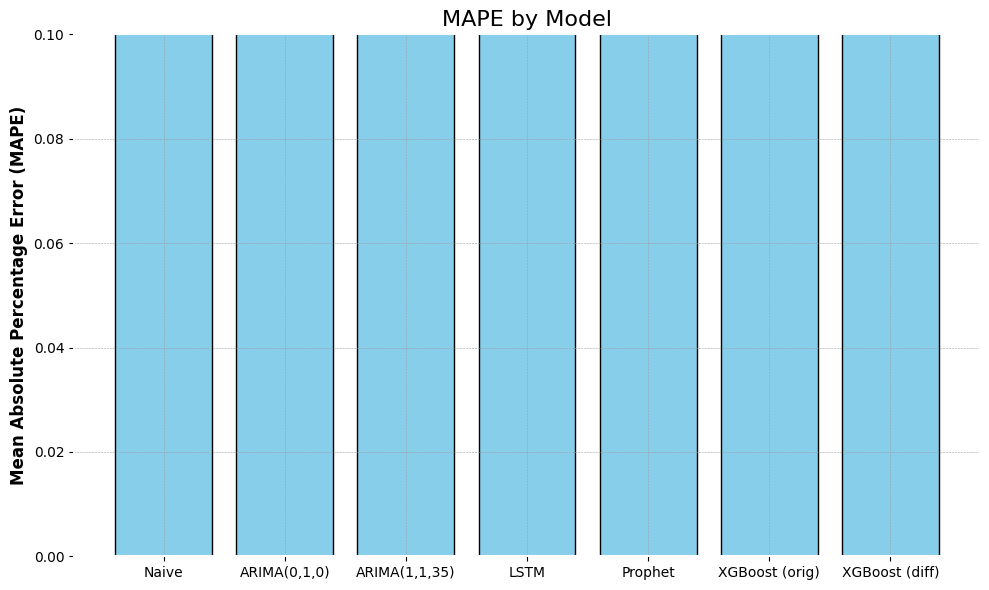

In [59]:
# Sort if you want (optional)
df_sorted = df_metrics.sort_values("mape", ascending=True)

filt = df_metrics["model"] == "XGBoost (ST original)"
df_sorted.loc[filt, "model"] = "XGBoost (orig)"
filt = df_sorted["model"] == "XGBoost (ST diferenciada)"
df_sorted.loc[filt, "model"] = "XGBoost (diff)"

# Extract data
models = df_sorted["model"]
mae_values = df_sorted["mape"]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(models, mae_values, color="skyblue", edgecolor="black")

# Labels and title
plt.title("MAPE by Model", fontsize=16)
plt.ylabel("Mean Absolute Percentage Error (MAPE)", fontsize=12)
plt.xticks(rotation=0)  # Rotate x labels if needed

plt.ylim(0, .1)

# Layout and show
plt.tight_layout()
plt.show()

Se observa que debido a la dificultad de modelar la serie de tiempo analizada, la utilización del un modelo Naive que siempre prediga el valor del dia anterior otorga la mejor performance. La volatilidad del precio de las criptomonedas suele verse fuertemente afectada por imprevisibles no recurrentes lo que genera que la sola utilización de modelos out-of-the-box no es suficiente para capturar esas dinámicas. Para mejorar el baseline, entonces, será necesario incorporar conocimiento de dominio en tiempo real al análisis de la serie temporal.

### Mejoras futuras <a class="anchor" id="mejoras-futuras"></a>

- En el modelo XBoost, se podrían agregar más características, como más rezagos o más medias moviles. También se le puede agregar un poco de ruido a estas nuevas características e incluir la variable volumen para ver si afecta el precio de cierre. Finalmente, se debe realizar optimización de hiperparámetros.
- En el modelo LSTM, dado que en la época 10 ya converge, habría que agregar una función callback *earlyStopping* de Keras. También sería positivo realizar una búsqueda de hiperparámetros para encontrar la mejor arquitectura y los mejores hiperparámetros para el modelo. Por último, se podría agregar un dropout para evitar el sobreajuste y probar con la serie diferenciada.